In [1]:
import os 
os.environ["HTTP_PROXY"] = "http://127.0.0.1:9000/localproxy.pac"
import time
import numpy as np
import pandas as pd
import pyttsx3

import speech_recognition as sr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import joblib
import collections as clct
engine = pyttsx3.init()
df_m=pd.read_csv("../Datasets/national_names_shuf.csv")[0:480000]
df_m.head()
df_m.isnull().values.any()
df_m.sex.unique()
df_m.sex=[0 if each=="M" else 1 for each in df_m.sex]
y=df_m.sex
def clean(word):
    return re.sub('[^a-zA-Z]','',word)
df_m["name"]=df_m["name"].apply(clean)
df_m["name"]=df_m["name"].str.lower()

### Load MNB Model 

In [43]:
cv_mnb = CountVectorizer()
Xfeatures=df_m["name"]
X_mnb = cv_mnb.fit_transform(Xfeatures)
#X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(X_mnb, y, test_size=0.2, random_state=42)
filename = 'mnb_model.sav'
loaded_mnb_model = joblib.load(filename)
"""result = loaded_mnb_model.score(X_test_mnb, y_test_mnb)
print(result)"""

'result = loaded_mnb_model.score(X_test_mnb, y_test_mnb)\nprint(result)'

In [44]:
def genderpredictor(a):
    test_name = [a]
    vector = cv_mnb.transform(test_name).toarray()
    if loaded_mnb_model.predict(vector) == 1:
        return "Female"
    else:
        return "Male"
"""
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Say something!")
    audio = r.listen(source)
str1=r.recognize_google(audio,language="fr-FR").lower()
print("you said ",str1)
"""

'\nr = sr.Recognizer()\nwith sr.Microphone() as source:\n    print("Say something!")\n    audio = r.listen(source)\nstr1=r.recognize_google(audio,language="fr-FR").lower()\nprint("you said ",str1)\n'

In [49]:
#print(genderpredictor("rachid"))
#df_m.drop_duplicates(subset ="name",keep = 'first', inplace = True)
print(df_m.loc[df_m["name"] == "rachid", "count"].sum())
"""
out=str1+" is a "+genderpredictor("str1")
print(str(out))
engine.say(out)
engine.runAndWait()
"""

13257


'\nout=str1+" is a "+genderpredictor("str1")\nprint(str(out))\nengine.say(out)\nengine.runAndWait()\n'

### Validation

In [5]:
df_v=pd.read_csv("../Datasets/national_names_shuf.csv")[480000:-1] #20% du dataset for validation
df_v["name"]=df_v["name"].apply(clean)
df_v.drop(["year","count"],axis=1)
def predvalues():
    val=[]
    for name in df_v["name"]:
        val.append(genderpredictor(name)[0])
    return val
exact_values=df_v["sex"].values.tolist()
val=predvalues()

In [6]:
val_clt=clct.Counter(val)
exact_values_clt=clct.Counter(exact_values)
error_mnb=(abs(val_clt['F']-exact_values_clt['F'])+abs(val_clt['M']-exact_values_clt['M']))/len(val)
print("Validation Score MNB: ",error_mnb)

Validation Score MNB:  0.0036297041791094027


### Load Decision Tree Classifier

In [2]:
def features(name):
    name = name.lower()
    return {
        'first-letter': name[0], # First letter
        'first2-letters': name[0:2], # First 2 letters
        'first3-letters': name[0:3], # First 3 letters
        'last-letter': name[-1],
        'last2-letters': name[-2:],
        'last3-letters': name[-3:],
    }
features = np.vectorize(features)

In [3]:
filename = 'dtree_model.sav'

X_train_features_dtree = features(df_m['name'])

dv_dtree = DictVectorizer()

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_train_features_dtree , y, test_size=0.2, random_state=42)
dv_dtree.fit_transform(X_train_tree)
loaded_dtree_model = joblib.load(filename)
#y_pred_tree= loaded_dtree_model.predict(dv_dtree.transform(X_test_tree))
#accuracy_dtree=metrics.accuracy_score(y_test_tree, y_pred_tree)
#print(accuracy_dtree)

In [5]:
def genderpredictor_tree(a):
    test_name_tree = [a]
    vector_tree = dv_dtree.transform(features(test_name_tree)).toarray()
    if loaded_dtree_model.predict(vector_tree) == 1:
        return "Female"
    else:
        return "Male"
"""
r_tree = sr.Recognizer()
with sr.Microphone() as source:
    print("Say something!")
    audio = r_tree.listen(source)
str2=r_tree.recognize_google(audio,language="fr-FR").lower()
print("you said ",str2)
"""

'\nr_tree = sr.Recognizer()\nwith sr.Microphone() as source:\n    print("Say something!")\n    audio = r_tree.listen(source)\nstr2=r_tree.recognize_google(audio,language="fr-FR").lower()\nprint("you said ",str2)\n'

In [6]:
print(genderpredictor_tree("rach"))
"""
out_tree=str2+" is a "+genderpredictor_tree(str2)
print(str(out_tree))
engine.say(out_tree)
engine.runAndWait()
"""

Male


'\nout_tree=str2+" is a "+genderpredictor_tree(str2)\nprint(str(out_tree))\nengine.say(out_tree)\nengine.runAndWait()\n'

### Validation

In [11]:
df_v=pd.read_csv("../Datasets/national_names_shuf.csv")[480000:-1] #20% du dataset for validation
df_v["name"]=df_v["name"].apply(clean)
df_v.drop(["year","count"],axis=1)
def predvalues_tree():
    val=[]
    for name in df_v["name"]:
        val.append(genderpredictor_tree(name)[0])
    return val
exact_values_tree=df_v["sex"].values.tolist()
val_tree=predvalues_tree()

In [12]:
val_tree_clt=clct.Counter(val_tree)
exact_values_tree_clt=clct.Counter(exact_values_tree)
error_dtree=(abs(val_tree_clt['F']-exact_values_tree_clt['F'])+abs(val_tree_clt['M']-exact_values_tree_clt['M']))/len(val_tree)
print("Validation Score DTree: ",error_dtree)

Validation Score DTree:  0.014848789823629374


### Load Random Forest

In [13]:
filename = 'rf_model.sav'
X_train_features_randomForrest = features(df_m['name'])

dv_randomForrest = DictVectorizer()
X_train_randomForrest, X_test_randomForrest, y_train_randomForrest, y_test_randomForrest = train_test_split(X_train_features_randomForrest , y, test_size=0.33, random_state=42)
dv_randomForrest.fit_transform(X_train_randomForrest)
loaded_rF_model = joblib.load(filename)
y_pred_rForest= loaded_rF_model.predict(dv_randomForrest.transform(X_test_randomForrest))
accuracy_rF=metrics.accuracy_score(y_test_randomForrest, y_pred_rForest)
print(accuracy_rF)

0.9463383838383839


In [14]:
def genderpredictor_r(a):
    test_name_tree = [a]
    vector_tree = dv_randomForrest.transform(features(test_name_tree)).toarray()
    if loaded_rF_model.predict(vector_tree) == 1:
        return "Female"
    else:
        return "Male"

### Validation

In [15]:
df_v=pd.read_csv("../Datasets/national_names_shuf.csv")[480000:-1] #20% du dataset for validation
df_v["name"]=df_v["name"].apply(clean)
df_v.drop(["year","count"],axis=1)
def predvalues_rf():
    val=[]
    for name in df_v["name"]:
        val.append(genderpredictor_r(name)[0])
    return val
exact_values_rf=df_v["sex"].values.tolist()
#print(genderpredictor_r("rachid"))

In [16]:
val_rf=predvalues_rf()
val_rf_clt=clct.Counter(val_rf)
exact_values_rf_clt=clct.Counter(exact_values_rf)
print(val_rf_clt['F'])
print(exact_values_rf_clt['F'])
error_rf=(abs(val_rf_clt['F']-exact_values_rf_clt['F'])+abs(val_rf_clt['M']-exact_values_rf_clt['M']))/len(val_rf)
print("Validation Score RForest: ",error_rf)

65326
66024
Validation Score RForest:  0.01151606144099256


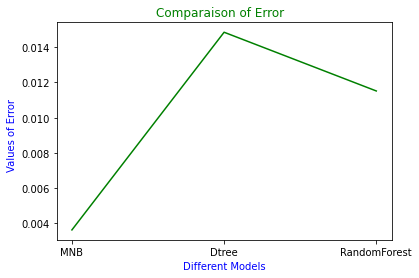

In [17]:
list_accuracy=[error_mnb,error_dtree,error_rf]
x=['MNB','Dtree','RandomForest']
plt.plot(x,list_accuracy,label='linear',color='g')
plt.xlabel('Different Models').set_color('blue')
plt.ylabel('Values of Error  ').set_color('blue')
plt.title('Comparaison of Error  ').set_color('green')